# Unsupervised learning methods for rapid data analysis @ NSLS-II

<img src="resources/nsls2.PNG" alt="NSLS2" style="width: 450px; height: 250px;"/>

### Dan Olds, Hard X-ray Scattering and Spectroscopy, PDF, NSLS-II 
### NSLS-II and CFN Users' Meeting 2022

While 

In [1]:
from tiled.client import from_uri, from_profile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load the data

In [2]:
c = from_uri("https://tiled-demo.blueskyproject.io/api")

Get the list of BaTiO3 variable temperature data

In [3]:
data = c['um2022']['olds']['BaTiO3_VT']

Happen to have stuffed metadata about temperature into a log file, let's take a look at it real quick.

Let's read all this data into a dataframe (because it's slow if we want to read each time).

In [4]:
data = c['um2022']['olds']['BaTiO3_VT']

file_list = sorted(list(data))

temp_df_list = []
for i in range(len(file_list)):
    temp_df_list.append(data[file_list[i]].read())

bto_data = pd.concat(temp_df_list,axis=1)

T_setpoints = np.arange(100,502,2,dtype=float)

bto_data.columns = T_setpoints

In [5]:
expected_Ttransitions = [196, 285, 401]


### Look at data

In [6]:
def make_colormap(num_ids,use_cmap='viridis'):
    num_colors = (num_ids)
    cm = plt.cm.get_cmap(name=use_cmap)
    currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]
    return currentColors

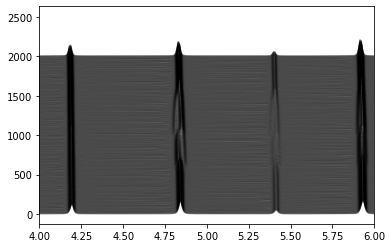

In [7]:
plt.figure()
for i in range(len(bto_data.columns)):
    plt.plot(bto_data.iloc[:,i]+10*i,color='k',alpha=.5);
plt.xlim(4,6);

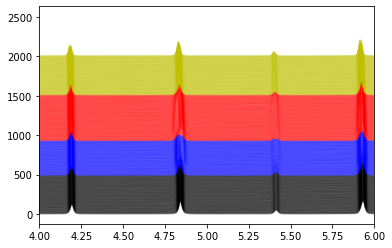

In [8]:
plt.figure()
clist = ['k','b','r','y']

for i in range(len(bto_data.columns)):
    
    this_t = bto_data.columns[i]
    
    use_c = 0
    if this_t > expected_Ttransitions[0]:
        use_c += 1
    if this_t > expected_Ttransitions[1]:
        use_c += 1
    if this_t > expected_Ttransitions[2]:
        use_c += 1
        
        
    plt.plot(bto_data.iloc[:,i]+10*i,color=clist[use_c],alpha=.5);
plt.xlim(4,6);

Let's make a waterfall plot of these.

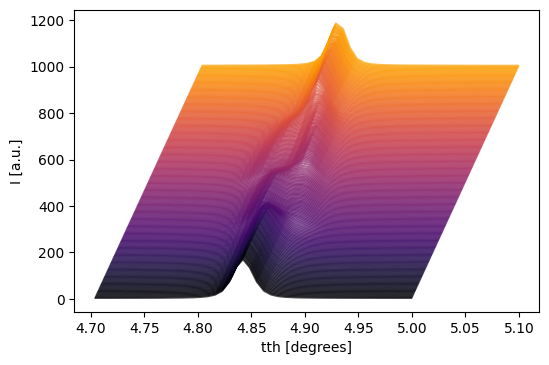

In [9]:
plt.figure(dpi=100)
cc = make_colormap(len(bto_data.columns)+50, use_cmap='inferno')

tth = bto_data.loc[4.7:5].index

for i in range(len(bto_data.columns)):
    this_t = bto_data.columns[i]
    plt.plot(tth+i*.0005,bto_data.loc[4.7:5,this_t]+i*5,c=cc[i],alpha=.7)
    
plt.xlabel('tth [degrees]');
plt.ylabel('I [a.u.]');

### Heirarchical Clustering

Short intro on heirarchical clustering.

In [10]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster
from scipy.spatial.distance import pdist

In [ ]:
dend = sch.dendrogram(sch.linkage(bto_data.loc[4.7:5,:].T, method = "single"))

In [ ]:
# calculate pairwise distances between observations in n-dimensional space.  
y = pdist(bto_data.loc[4.7:5,:].T)
y_all = pdist(bto_data.loc[1:15,:].T)

# perform Ward's linkage on a condensed distance matrix.
Z = ward(y)
Z_all = ward(y_all)

# form cluster label from the hierarchical clustering defined by the given linkage matrix
wardlabel = fcluster(Z, 500, criterion='distance')
wardlabel_all = fcluster(Z_all, 900, criterion='distance')

print (max(wardlabel_all))

In [ ]:
plt.figure()
plt.plot(T_setpoints,wardlabel_all,'.')
for t in expected_Ttransitions:
    plt.plot((t,t),(1,4),c='k',ls='--')

In [ ]:
plt.figure(dpi=100)
cc = make_colormap(6, use_cmap='Dark2')

tth = bto_data.loc[4.7:5].index

for i in range(len(bto_data.columns)):
    this_t = bto_data.columns[i]
    plt.plot(tth+i*.0005,bto_data.loc[4.7:5,this_t]+i*5,c=cc[wardlabel_all[i]-1],alpha=.7)
    
plt.xlabel('tth [degrees]');
plt.ylabel('I [a.u.]');

### Principle Component Analysis (PCA)

Short intro on PCA.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=4)
pca.fit(bto_data.loc[4.7:5,:])



In [ ]:
plt.figure()

pca_weights = pca.components_.T
pca_comps = pca.fit_transform(bto_data.loc[4.7:5,:])

rescale = pca_weights.max(axis=0)
pca_weights /= rescale
pca_comps*=rescale


plt.subplot(211)
plt.plot(T_setpoints, pca_weights);

for t in expected_Ttransitions:
    plt.plot((t,t),(0,1),c='k',ls='--')
    
plt.subplot(212)
plt.plot(pca_comps);

### Non-negative Matrix Factorizatoin

In [ ]:
from sklearn.decomposition import NMF


In [ ]:
model = NMF(n_components=4, init='nndsvda', random_state=0,max_iter=1000)
W = model.fit_transform(bto_data.loc[4.7:5,:].T)
H = model.components_

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(H.T/np.max(H.T,axis=0));

plt.subplot(212)
plt.plot(T_setpoints,W/np.max(W,axis=0));

for t in expected_Ttransitions:
    plt.plot((t,t),(0,1),c='k',ls='--')

### Constrained Matrix Factorization

In [ ]:
%matplotlib widget
from cmf_utils import AutoNMFCompanion


In [ ]:
companion = AutoNMFCompanion(4,
                             q=bto_data.loc[4.7:5,:].index.to_numpy(),
                             normalize=True
                             )


In [ ]:
companion.tell_many(T_setpoints[:, None], bto_data.loc[4.7:5,:].to_numpy().T)
companion.report()

In [ ]:
plt.figure()
plt.subplot(211)
for i in range(len(companion.dependent_components)):
    plt.plot(companion.dependent_components[i]+i);

plt.subplot(212)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, companion.dependent_weights.T[i]);
    

In [ ]:
plt.figure()
plt.subplot(211)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, companion.dependent_weights.T[i]);
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
    
plt.subplot(212)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, np.gradient(companion.dependent_weights.T[i]));
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')

## Comparison of PCA, NMF, and CMF

In [ ]:
plt.figure()

plt.subplot(311)
plt.plot(T_setpoints, pca_weights);

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
    
plt.subplot(313)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, companion.dependent_weights.T[i]);
    
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
   
plt.subplot(312)
plt.plot(T_setpoints,W/np.max(W,axis=0));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')

Looking at PCA

In [ ]:
plt.close('all')

### Gradient of NMF

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(T_setpoints,W/np.max(W,axis=0));
plt.subplot(212)
for i in range(4):
    plt.plot(T_setpoints,np.gradient(W.T[i]/np.max(W.T[i],axis=0)));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')

### Gradient Comparison

In [ ]:
plt.figure()

plt.subplot(311)

for i in range(4):
    plt.plot(T_setpoints, np.gradient(pca_weights.T[i]));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')

###################

plt.subplot(312)
for i in range(4):
    plt.plot(T_setpoints,np.gradient(W.T[i]/np.max(W.T[i],axis=0)));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
    
###############
    
plt.subplot(313)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, np.gradient(companion.dependent_weights.T[i]));
    
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
   


In [ ]:
plt.figure()

plt.subplot(311)

for i in range(4):
    plt.plot(T_setpoints, np.gradient(np.gradient(pca_weights.T[i])));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')

###################

plt.subplot(312)
for i in range(4):
    plt.plot(T_setpoints,np.gradient(np.gradient(W.T[i]/np.max(W.T[i],axis=0))));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
    
###############
    
plt.subplot(313)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, np.gradient(np.gradient(companion.dependent_weights.T[i])));
    
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
   
